In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import math
import matplotlib.pyplot as plt

In [159]:
data_df = pd.read_csv("data.csv", parse_dates=['date'], index_col = "date").asfreq('D') # reading data 
print(data_df.info())
print(data_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790 entries, 2020-05-02 to 2022-06-30
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       790 non-null    int64  
 1   temperature  769 non-null    float64
 2   media_spend  790 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.7 KB
None
            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0
...            ...          ...          ...
2022-06-26      89    12.669216          0.0
2022-06-27      77     9.819516          0.0
2022-06-28      97    18.834372          0.0
2022-06-29      80          NaN          0.0
2022-06-30      79    11.982388          0.0

[790 rows x 3 col

### Data Preprocessing

In [160]:
data_df.isnull().sum()

orders          0
temperature    21
media_spend     0
dtype: int64

In [161]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790 entries, 2020-05-02 to 2022-06-30
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       790 non-null    int64  
 1   temperature  769 non-null    float64
 2   media_spend  790 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.7 KB


In [162]:
data_df["temperature"]= data_df["temperature"].interpolate(method='linear') 
# Interpolation Method: There are different methods available, and you can use method="time".
print("Eksik değerler doldurulmuş veri çerçevesi:")
print(data_df)

Eksik değerler doldurulmuş veri çerçevesi:
            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0
...            ...          ...          ...
2022-06-26      89    12.669216          0.0
2022-06-27      77     9.819516          0.0
2022-06-28      97    18.834372          0.0
2022-06-29      80    15.408380          0.0
2022-06-30      79    11.982388          0.0

[790 rows x 3 columns]


In [163]:
MissingData=data_df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values') # check missing values 
MissingData


,Variables,Missing Values
0,orders,0
1,temperature,0
2,media_spend,0


In [164]:
from scipy.stats import zscore # Identifying Outliers 

z_scores = zscore(data_df["orders"])
outliers = data_df[abs(z_scores) > 3] 

print("Outliers:")
print(outliers)

Outliers:
            orders  temperature  media_spend
date                                        
2020-06-03    2952     9.493584          0.0
2021-01-14    2816    -4.468595          0.0
2021-03-22    4080    20.155265          0.0


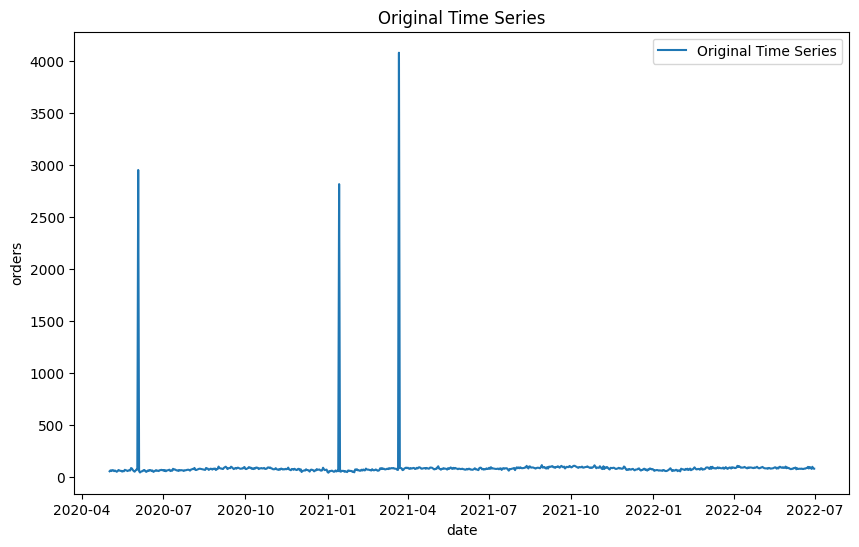

In [165]:
plt.figure(figsize=(10, 6)) 
plt.plot(data_df.index, data_df['orders'], label='Original Time Series') 
plt.xlabel('date')
plt.ylabel('orders')
plt.title('Original Time Series') 
plt.legend()
plt.show()

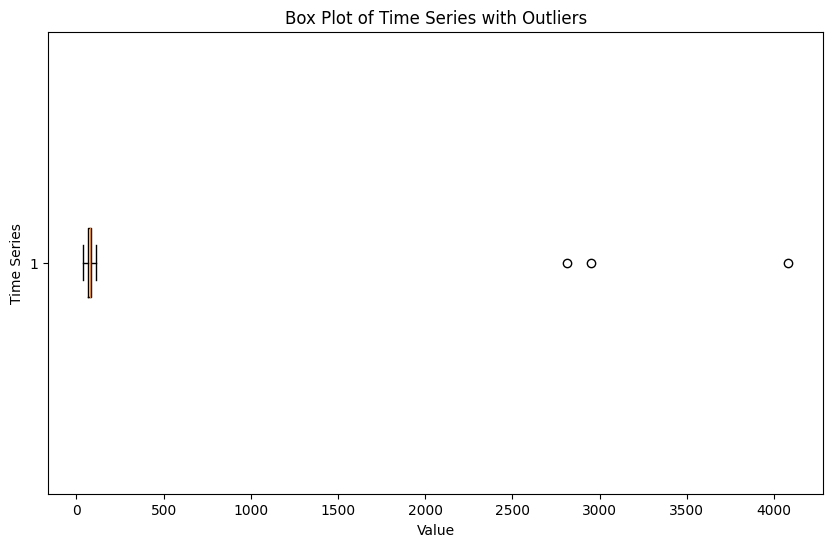

In [167]:
target_series = data_df['orders']

# Create a box plot to visualize outliers
plt.figure(figsize=(10, 6))
plt.boxplot(target_series, vert=False)
plt.title('Box Plot of Time Series with Outliers')
plt.xlabel('Value')
plt.ylabel('Time Series')
plt.show()

In [168]:
z_scores = np.abs((data_df - data_df.mean()) / data_df.std()) # removing outliers with z_scores method. 

threshold = 3    
data_m_df_outliers = data_df[(z_scores < threshold).all(axis=1)]    


print(data_m_df_outliers)

            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0
...            ...          ...          ...
2022-06-26      89    12.669216          0.0
2022-06-27      77     9.819516          0.0
2022-06-28      97    18.834372          0.0
2022-06-29      80    15.408380          0.0
2022-06-30      79    11.982388          0.0

[760 rows x 3 columns]


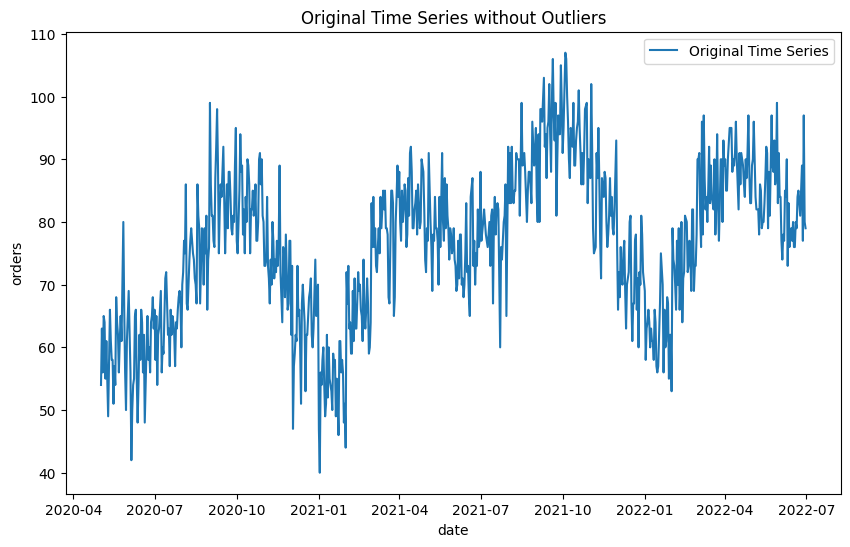

In [169]:
plt.figure(figsize=(10, 6)) 
plt.plot(data_m_df_outliers.index, data_m_df_outliers['orders'], label='Original Time Series')
plt.xlabel('date')
plt.ylabel('orders')
plt.title('Original Time Series without Outliers')
plt.legend()
plt.show()

In [176]:
# Assuming 'ts' is your time series data (a pandas Series or DataFrame)
result = adfuller(data_m_df_outliers["orders"])

# Extracting the test statistics and p-value
test_statistic = result[0]
p_value = result[1]

# Print the results
print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)

# Interpret the results
if p_value <= 0.05:
    print("p-value is less than or equal to 0.05. The data is likely stationary.")
else:
    print("p-value is greater than 0.05. The data is likely non-stationary.")

ADF Test Statistic: -2.4721826106267644
p-value: 0.12239011845564962
p-value is greater than 0.05. The data is likely non-stationary.


In [177]:
first_diff = data_m_df_outliers["orders"].diff().dropna() #order = (p, 1, q)

adf_test = adfuller(first_diff)
p_value = adf_test[1]
print(p_value)

6.847717617048841e-13


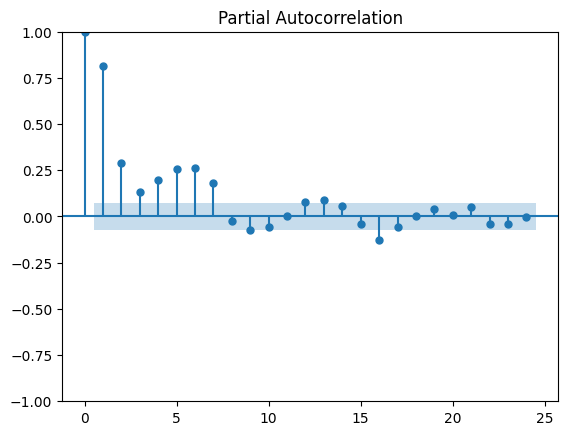

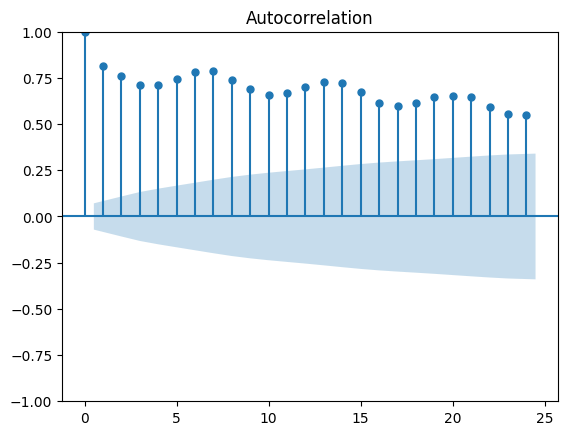

In [172]:
fig = plot_pacf(data_m_df_outliers["orders"], lags=24)  #We cannot clearly observe the tail off or cut off in the graphs; they seem inconclusive, indicating that we might consider
                                                        #using an ARMA model. This way, our model will consider both past values and past errors.
fig = plot_acf(data_m_df_outliers["orders"], lags=24)   

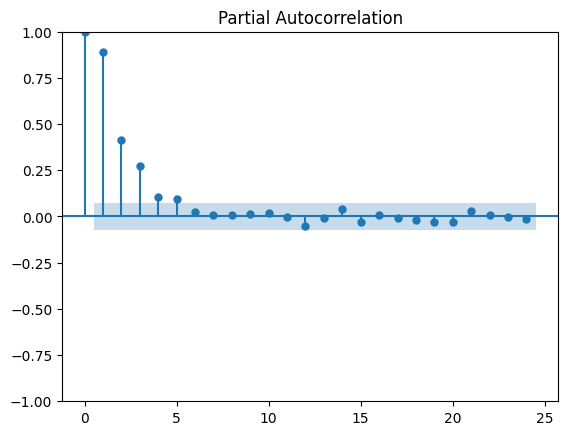

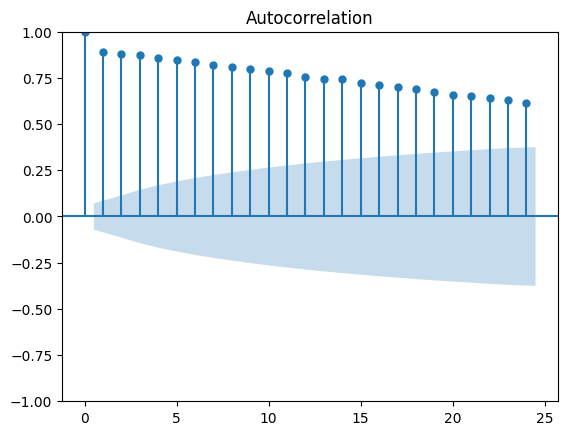

In [173]:
fig = plot_pacf(data_m_df_outliers["temperature"], lags=24)  
fig = plot_acf(data_m_df_outliers["temperature"], lags=24)

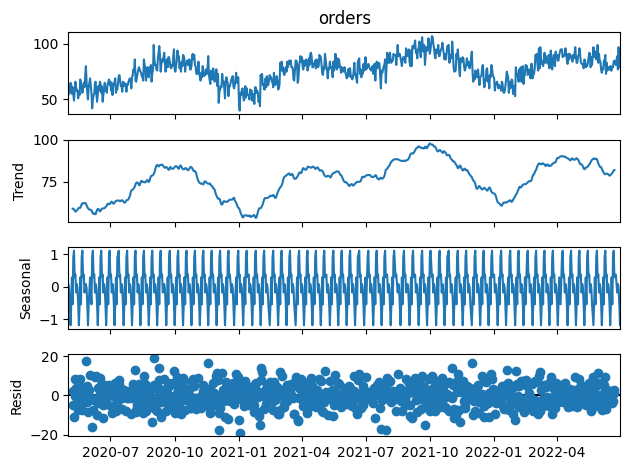

In [174]:
from statsmodels.tsa.seasonal import seasonal_decompose  

decomposed_data = seasonal_decompose(data_m_df_outliers["orders"], model="add", period=12)  # There is seasonality...  
                                                            #Because our data is not stationary and exhibits seasonality, the SARIMA model will be more suitable.
decomposed_plot = decomposed_data.plot()   

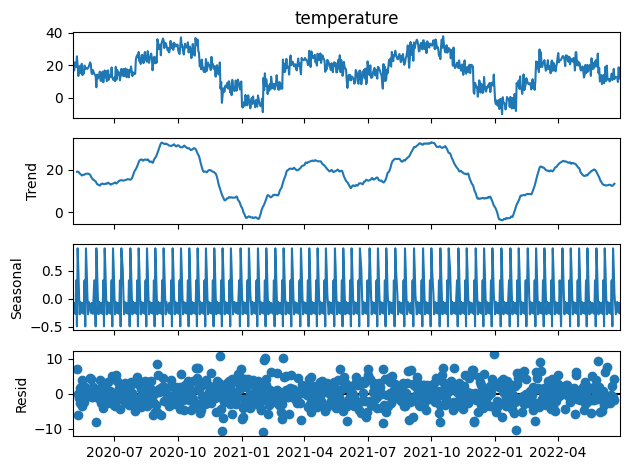

In [178]:
from statsmodels.tsa.seasonal import seasonal_decompose  

decomposed_data = seasonal_decompose(data_m_df_outliers["temperature"], model="add", period=12)  # There is seasonality...
decomposed_plot = decomposed_data.plot() 

### GridSearch

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import math

# Assuming your target column is named 'orders'
target_series = data_m_df_outliers['orders']

# Exogenous variables
exog_variables = data_m_df_outliers[['temperature', 'media_spend']]  # Adjust as needed

# Split the data_m_df_outliers into training and test sets (90% train, 10% test)
test_size = math.ceil(len(data_m_df_outliers) * 0.10)
train_series = target_series[:-test_size]
test_series = target_series[-test_size:]
exog_train = exog_variables[:-test_size]
exog_test = exog_variables[-test_size:]

# Define the range of values to search for p, d, q, P, D, Q
p_values = range(0, 2)  # You can adjust the range
d_values = range(0, 2)  # You can adjust the range
q_values = range(0, 2)  # You can adjust the range
P_values = range(0, 2)  # You can adjust the range
D_values = range(0, 2)  # You can adjust the range
Q_values = range(0, 2)  # You can adjust the range
S_values = [7]  # Weekly seasonality

# Initialize variables for best configuration and lowest RMSE
best_rmse = float('inf')
best_config = None

# Perform grid search
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, 7)  # S=7 for weekly seasonality

    # Fit the SARIMAX model on the training data
    model = SARIMAX(train_series, exog=exog_train, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Forecast using the fitted model on the test data
    forecast_steps = len(test_series)
    forecast = results.get_forecast(steps=forecast_steps, exog=exog_test)

    # Calculate RMSE on the test set
    rmse = sqrt(mean_squared_error(test_series, forecast.predicted_mean))

    # Update best configuration if RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_config = (p, d, q, P, D, Q)

print("Best RMSE:", best_rmse)
print("Best Configuration (p, d, q, P, D, Q):", best_config)
#Best Configuration (p, d, q, P, D, Q): (0, 1, 1, 1, 0, 0)

### Modeling

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07418D+00    |proj g|=  1.46316D-01

At iterate    5    f=  2.91429D+00    |proj g|=  8.24555D-03

At iterate   10    f=  2.91379D+00    |proj g|=  1.06050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.749D-06   2.914D+00
  F =   2.9137939904547903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/xp/gs5jj49d2n1_y881z2h8pqmm0000gn/T/ipykernel_38753/1000725517.py:29: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test_series - forecast.predicted_mean) / test_series)) * 100


MAE: 3.5019968228659613
RMSE: 4.455241363667408
MAPE: nan


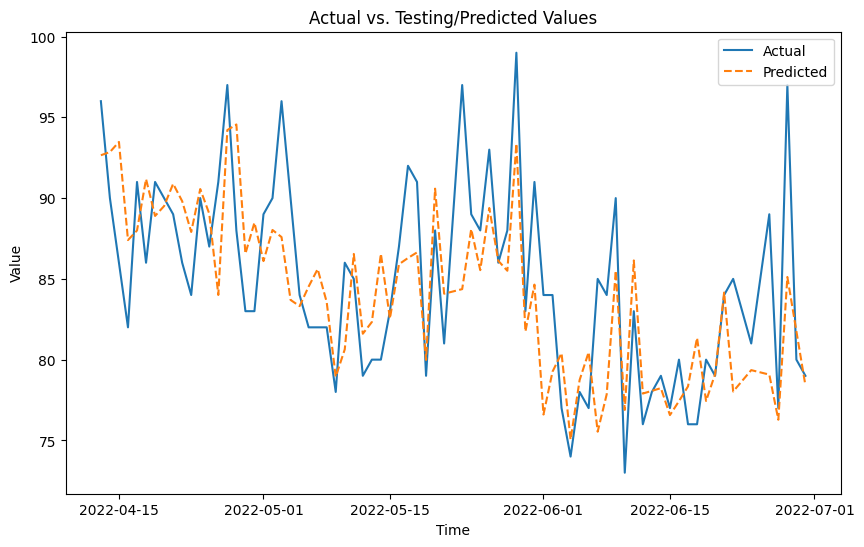

In [192]:
# Assuming your target column is named 'orders'
target_series = data_m_df_outliers['orders']

# Exogenous variables
exog_variables = data_m_df_outliers[['temperature', 'media_spend']]  # Adjust as needed

# Split the data_m_df_outliers into training and test sets (90% train, 10% test)
test_size = math.ceil(len(data_m_df_outliers) * 0.10)
train_series = target_series[:-test_size]
test_series = target_series[-test_size:]
exog_train = exog_variables[:-test_size]
exog_test = exog_variables[-test_size:]

# Define the SARIMAX model with the specified parameters Best Configuration (p, d, q, P, D, Q): (0, 1, 1, 1, 0, 0)
order = (0, 1, 1)           # (p, d, q)
seasonal_order = (1, 0, 0, 7)  # (P, D, Q, S) with S=7 for weekly seasonality

# Fit the SARIMAX model on the training data
model = SARIMAX(train_series, exog=exog_train, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Forecast using the fitted model on the test data
forecast_steps = len(test_series)
forecast = results.get_forecast(steps=forecast_steps, exog=exog_test)

# Calculate MAE, RMSE, and MAPE on the test set
mae = mean_absolute_error(test_series, forecast.predicted_mean)
rmse = sqrt(mean_squared_error(test_series, forecast.predicted_mean))
mape = np.mean(np.abs((test_series - forecast.predicted_mean) / test_series)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_series.index, test_series, label='Actual')
plt.plot(test_series.index, forecast.predicted_mean, label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs. Testing/Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07418D+00    |proj g|=  1.46316D-01

At iterate    5    f=  2.91429D+00    |proj g|=  8.24555D-03

At iterate   10    f=  2.91379D+00    |proj g|=  1.06050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.749D-06   2.914D+00
  F =   2.9137939904547903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 9.208209636015116
RMSE: 11.618599621234544
MAPE: nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/xp/gs5jj49d2n1_y881z2h8pqmm0000gn/T/ipykernel_38753/1910654897.py:29: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_train = np.mean(np.abs((train_series - forecast.predicted_mean) / train_series)) * 100


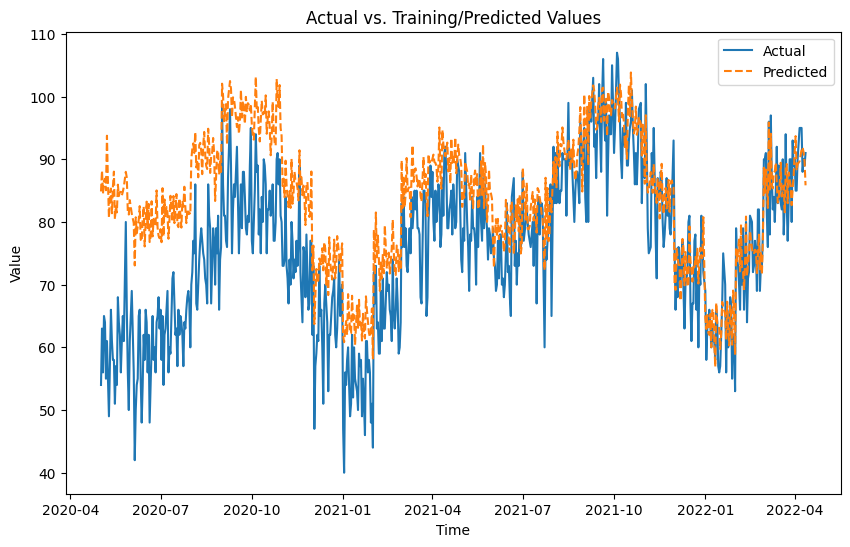

In [191]:
# Assuming your target column is named 'orders'
target_series = data_m_df_outliers['orders']

# Exogenous variables
exog_variables = data_m_df_outliers[['temperature', 'media_spend']]  # Adjust as needed

# Split the data_m_df_outliers into training and test sets (90% train, 10% test)
test_size = math.ceil(len(data_m_df_outliers) * 0.10)
train_series = target_series[:-test_size]
test_series = target_series[-test_size:]
exog_train = exog_variables[:-test_size]
exog_test = exog_variables[-test_size:]

# Define the SARIMAX model with the specified parameters Best Configuration (p, d, q, P, D, Q): (0, 1, 1, 1, 0, 0)
order = (0, 1, 1)           # (p, d, q)
seasonal_order = (1, 0, 0, 7)  # (P, D, Q, S) with S=7 for weekly seasonality

# Fit the SARIMAX model on the training data
model = SARIMAX(train_series, exog=exog_train, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Forecast using the fitted model on the test data
forecast_steps = len(train_series)
forecast = results.get_forecast(steps=forecast_steps, exog=exog_train)

# Calculate MAE, RMSE, and MAPE on the test set
mae_train = mean_absolute_error(train_series, forecast.predicted_mean)
rmse_train = sqrt(mean_squared_error(train_series, forecast.predicted_mean))
mape_train = np.mean(np.abs((train_series - forecast.predicted_mean) / train_series)) * 100

print("MAE:", mae_train)
print("RMSE:", rmse_train)
print("MAPE:", mape_train)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(train_series.index, train_series, label='Actual')
plt.plot(train_series.index, forecast.predicted_mean, label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs. Training/Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##  Loading Fitted Data to Joblib

In [193]:
import joblib

# Assuming your target column is named 'orders'
target_series = data_m_df_outliers['orders']

# Exogenous variables
exog_variables = data_m_df_outliers[['temperature', 'media_spend']]  # Adjust as needed

# Define the SARIMAX model with the specified parameters
order = (0, 1, 1)           # (p, d, q)
seasonal_order = (1, 0, 0, 7) # (P, D, Q, S) with S=7 for weekly seasonality

# Fit the SARIMAX model on the entire dataset
model = SARIMAX(target_series, exog=exog_variables, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Save the fitted model using joblib
fitted_model_filename = 'fitted_sarimax_model.joblib'
joblib.dump(results, fitted_model_filename)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05986D+00    |proj g|=  1.48598D-01

At iterate    5    f=  2.90716D+00    |proj g|=  6.31894D-02

At iterate   10    f=  2.90407D+00    |proj g|=  2.58317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.935D-06   2.904D+00
  F =   2.9040716585075339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


['fitted_sarimax_model.joblib']